This is currently out-dated. This was the original pipeline that uses ndimage's rotate functionality. But it isn't accurate in doing triple axis rotation based off of our coordinates (the reference axes change after a single rotation), and takes a long time to process. Instead, a free-surfer script is being used instead to do all 3 rotations and translations at once.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# ! rm -rf content/NU_Radiology/

In [0]:
# ! git clone https://github.com/eyang9001/NU_Radiology.git
# ! pip install simpleitk

Cloning into 'NU_Radiology'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 154 (delta 19), reused 46 (delta 15), pack-reused 102
Receiving objects: 100% (154/154), 17.13 MiB | 16.20 MiB/s, done.
Resolving deltas: 100% (67/67), done.
     |████████████████████████████████| 42.5MB 72kB/s 


In [0]:
from sys import platform as sys_pf
# if sys_pf == 'darwin':
#     import matplotlib
#     matplotlib.use("TkAgg")
! pip install simpleitk
%matplotlib inline  
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import SimpleITK as sitk
from scipy import ndimage
import random
import math
import pickle
import time

mris_folder = 'NU_Radiology/mris/'
motion_folder = 'NU_Radiology/motions/'
image_shape = (256,256,176)
skip_rate = 1
rads_to_deg = 57.2958

     |████████████████████████████████| 42.5MB 69kB/s 


In [0]:
class mri(object):
    def __init__(self, filename):
        self.conv_file(filename)
        self.ks = np.fft.fftn(self.original)
        self.ks = np.fft.fftshift(self.ks)
        self.max = np.amax(self.original)
        self.min = np.amin(self.original)
        self.ks_vis = np.abs(self.ks)
        self.x, self.y, self.z = self.original.shape
        self.slices = self.x
        self.rate = skip_rate # The number of slices that are skipped for transformations
    
    def conv_file(self, filename):
        reader = sitk.ImageFileReader()
        reader.SetImageIO("NiftiImageIO")
        reader.SetFileName(filename)
        image = reader.Execute()

        # img1 = sitk.ReadImage(folder + item)  # alternative way to pull in image

        # convert image into np array & perform fft
        img = sitk.GetArrayFromImage(image)
        # Transpose the image so the first axis is Anterior-Posterior
        img = np.transpose(img, (2,1,0))
        self.original = img 
    
    def fft_back(self, kspace):
        # Produce the image given the kspace
        back_fft = np.fft.ifftn(kspace)
        return back_fft
    
    # modifies the whole 3d kspace and then returns a specific slice
    # returns the slice of the modified kspace as well as visual representation
    def mod_kspace_slice(self, trans, rot, slice_num):
        # Translations are passed in as [x, y, z]
        # Rotations are passed in as [yaw, pitch, roll] in degrees
        # rotation axes of (1,2) is nodding,(0,2) is shaking, (0,1) is cracking
        # rotation axes of (0,1) is nodding,(0,2) is shaking, (1,2) is cracking
        mod3d = self.ks.copy()
        mod_v = self.original.copy()
        mod_r = mod3d.real
        mod_i = mod3d.imag
        
        if rot != None:
            # Roll rotation
            mod_v = ndimage.rotate(mod_v, rot[0], (1,2), reshape = False)
            mod_r = ndimage.rotate(mod_r, rot[0], (1,2), reshape = False)
            mod_i = ndimage.rotate(mod_i, rot[0], (1,2), reshape = False)
            # Pitch rotation
            mod_v = ndimage.rotate(mod_v, rot[1], (0,1), reshape = False)
            mod_r = ndimage.rotate(mod_r, rot[1], (0,1), reshape = False)
            mod_i = ndimage.rotate(mod_i, rot[1], (0,1), reshape = False)
            # Yaw rotation
            mod_v = ndimage.rotate(mod_v, rot[2], (0,2), reshape = False)
            mod_r = ndimage.rotate(mod_r, rot[2], (0,2), reshape = False)
            mod_i = ndimage.rotate(mod_i, rot[2], (0,2), reshape = False)
        if trans != None:
            mod_v = ndimage.shift(mod_v, trans, mode='constant', cval=0)
            mod_r = ndimage.shift(mod_r, trans, mode='constant', cval=0)
            mod_i = ndimage.shift(mod_i, trans, mode='constant', cval=0)
        return mod_r[slice_num] + mod_i[slice_num] *1j, mod_v[slice_num]

    # Translating a specific slice
    # Returns the slice after translation
    def translate(self, space, slice_num, value):
        if space == 'v':
            slc = self.original[slice_num]
        elif space == 'k':
            slc = self.ks_vis[slice_num]
        tran = ndimage.shift(slc,value, mode='constant', cval=0)
        return tran
    
    # Rotating a specific slice
    # Returns the slice after rotation
    def rotate(self, space, slice_num, value, axis=None):
        # If the rotation is in visual space, or k-space
        if space == 'v':
            slc = self.original[slice_num]
            rot = ndimage.rotate(slc, value, reshape = False)
        elif space == 'k':
            slc = self.ks[slice_num]
            rot = ndimage.rotate(slc, value, reshape = False, cval=0)
        return rot
    
    # Displays a slice with an original slice
    def show_slice(self, img, slice_num, space):
        if space == 'v':
            slc = self.original[slice_num]
        elif space == 'k':
            slc = self.ks_vis[slice_num]
        plt.figure(figsize= (20,20))
        plt.subplot(121), plt.imshow(slc, cmap='gray')
        plt.title('Original'), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(img, cmap='gray')
        plt.title('New'), plt.xticks([]), plt.yticks([])
        
    def create_mod_slices(self, motion, verbose=True):
        modded_k = []
        modded_v = []
        trans_log = []
        global slice_time
        for i in np.arange(len(self.ks)):
            motion_step = int(i*motion.length/len(self.ks))
            if (i % self.rate == 0) and motion_step < motion.length :
                trans = [motion.trans_x[motion_step], motion.trans_y[motion_step], motion.trans_z[motion_step]]
                rot = [motion.yaw[motion_step], motion.pitch[motion_step], motion.roll[motion_step]]
                k, v = self.mod_kspace_slice(trans,rot,i)
                modded_k.append(k)
                modded_v.append(v)
                trans_log.append([i, motion.trans_x[motion_step], motion.trans_y[motion_step], motion.trans_z[motion_step], motion.yaw[motion_step], motion.pitch[motion_step], motion.roll[motion_step]])
                if verbose:
                    print('Slice #{} out of {} completed'.format(i, len(self.ks)))
                    # print('Slice time: ' + str(time.time() - slice_time)[0:5])
                    # slice_time = time.time()
            else:
                modded_k.append(self.ks[i])
                modded_v.append(self.original[i])
            # Here, the modded_v is only a visual representation of each slice's transformation
            # Returns transf_v as the blurred images
        transf_v = mri1.fft_back(modded_k)
        transf_v = self.transp_img(np.abs(transf_v))
        
        # transf_v will be left-right orientation while modded_v is anterior-posterior
        return transf_v, modded_v, trans_log
    
    def transp_img(self, data):
        return np.transpose(data, (2,1,0))
    
    def save_to_file(self, data, name):
        # Takes in 3d array and converts to 2d, then saves to file
        # If the file doesn't have imaginary component, set 'frm' as 'v'
        output_r=[]
        for sublist in data:
            for item in sublist:
                    output_r.append(item)
        np.savetxt(name, output_r, fmt="%s" ,delimiter=',')
    
    def show_rotations(self, data):
        plt.figure(figsize= (20,20))
        plots = []
        p_count = 0

        for i in np.arange(len(data)):
            if (i % self.rate == 0) and len(plots) < 50:
                plots.append(data[i])
                
        for i in range(10):
            for j in range(5):
                plt.subplot2grid((10,5), (i,j)), plt.imshow(plots[p_count], cmap='gray')
                p_count += 1
                if p_count == len(plots):
                    break
            if p_count == len(plots):
                break

class motion(object):
    # Rotations are taken in as [Roll, Pitch, Yaw]
    def __init__(self, filename):
        self.trans_scale = 1
        self.filename = filename
        self.raw = np.loadtxt(filename)
        self.length = len(self.raw)
        self.roll=[]
        self.pitch=[]
        self.yaw = []
        self.trans_x = []
        self.trans_y = []
        self.trans_z = []
        # go through motion file one line at a time
        for i in range(len(self.raw)):
            self.roll.append(self.raw[i][0]*180/math.pi)
            self.pitch.append(self.raw[i][1]*180/math.pi)
            self.yaw.append(self.raw[i][2]*180/math.pi)
            # Still need to figure out the conversion of translations from motion file
            self.trans_x.append(self.raw[i][3]*self.trans_scale)
            self.trans_y.append(self.raw[i][4]*self.trans_scale)
            self.trans_z.append(self.raw[i][5]*self.trans_scale)
            
def read_file(filename):
    data = np.loadtxt(filename, delimiter=",")
    data = np.reshape(data,(176,256,256))
    return data


In [0]:
# Testing rotations
mri1 = mri('/content/gdrive/My Drive/NU_Rad/mris/M01.nii')
motion1 = motion('/content/gdrive/My Drive/NU_Rad/motion/motion1.dat')

In [0]:
print('roll max: ' + str(np.amax(motion1.roll)))
print('roll min: ' + str(np.amin(motion1.roll)))
print('pitch max: ' + str(np.amax(motion1.pitch)))
print('pitch min: ' + str(np.amin(motion1.pitch)))
print('yaw max: ' + str(np.amax(motion1.yaw)))
print('yaw min: ' + str(np.amin(motion1.yaw)))

roll max: 0.9295495380863937
roll min: -1.8642270484392083
raw roll max: 0.0162237
raw roll min: -0.0325369
pitch max: 0.4216820403136125
pitch min: -0.3309868320489691
yaw max: 1.0590494589418624
yaw min: -0.16125667960838969


In [0]:
print('x max: ' + str(np.amax(motion1.trans_x)))
print('x min: ' + str(np.amin(motion1.trans_x)))
print('y max: ' + str(np.amax(motion1.trans_y)))
print('y min: ' + str(np.amin(motion1.trans_y)))
print('z max: ' + str(np.amax(motion1.trans_z)))
print('z min: ' + str(np.amin(motion1.trans_z)))

x max: 0.100458
x min: -0.829886
y max: 0.508183
y min: -0.816096
z max: 0.993653
z min: -1.05331


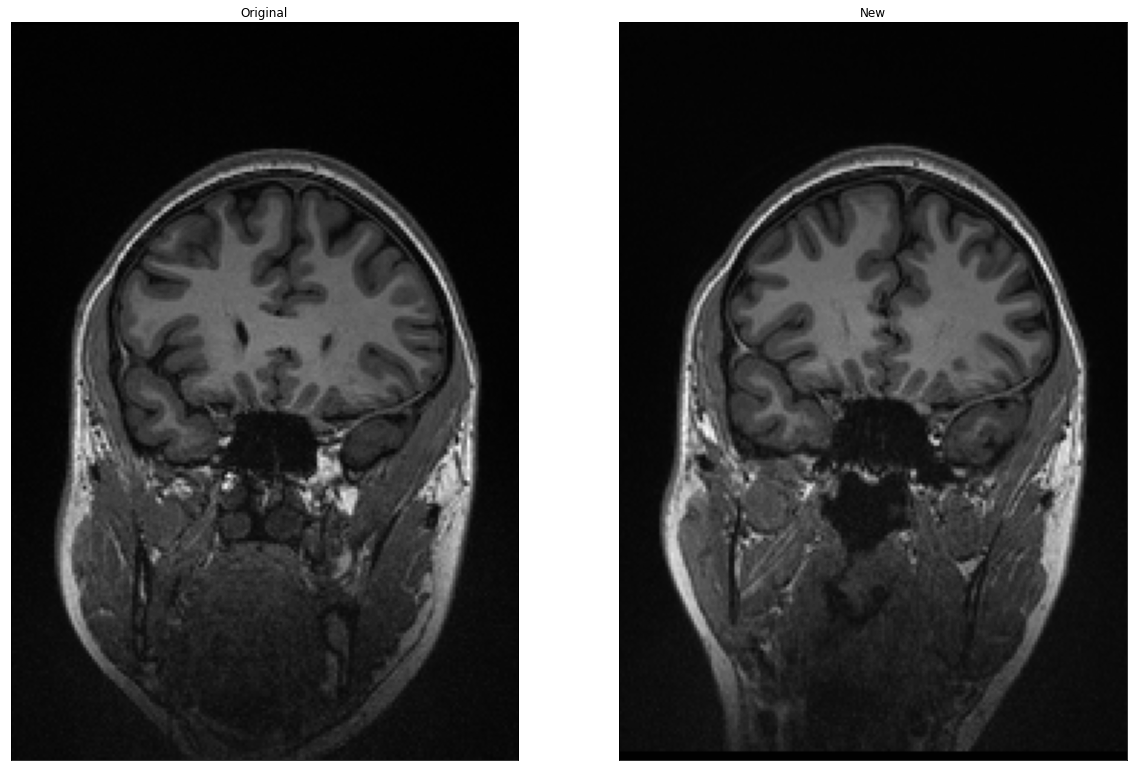

In [0]:
# Testing rotations for pitch
_, roted = mri1.mod_kspace_slice([0,0,0],[0,10,0],100)
mri1.show_slice(roted, 100, 'v')

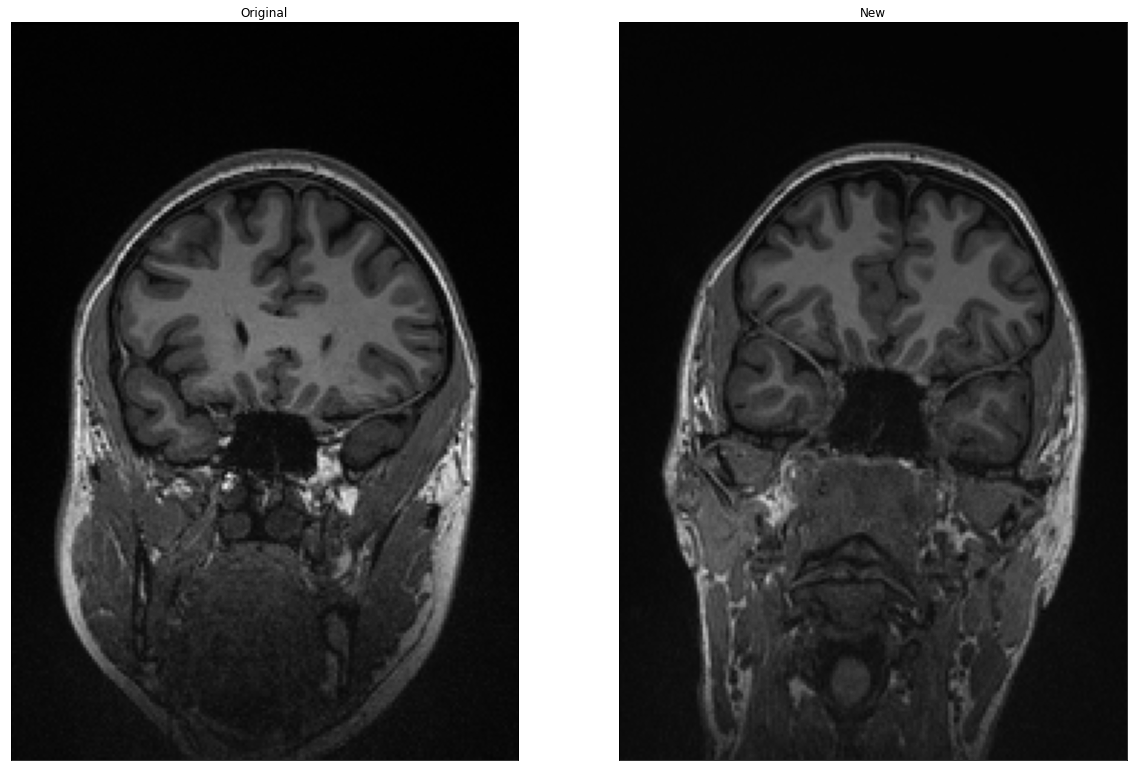

In [0]:
_, roted = mri1.mod_kspace_slice([0,0,0],[0,30,0],100)
mri1.show_slice(roted, 100, 'v')

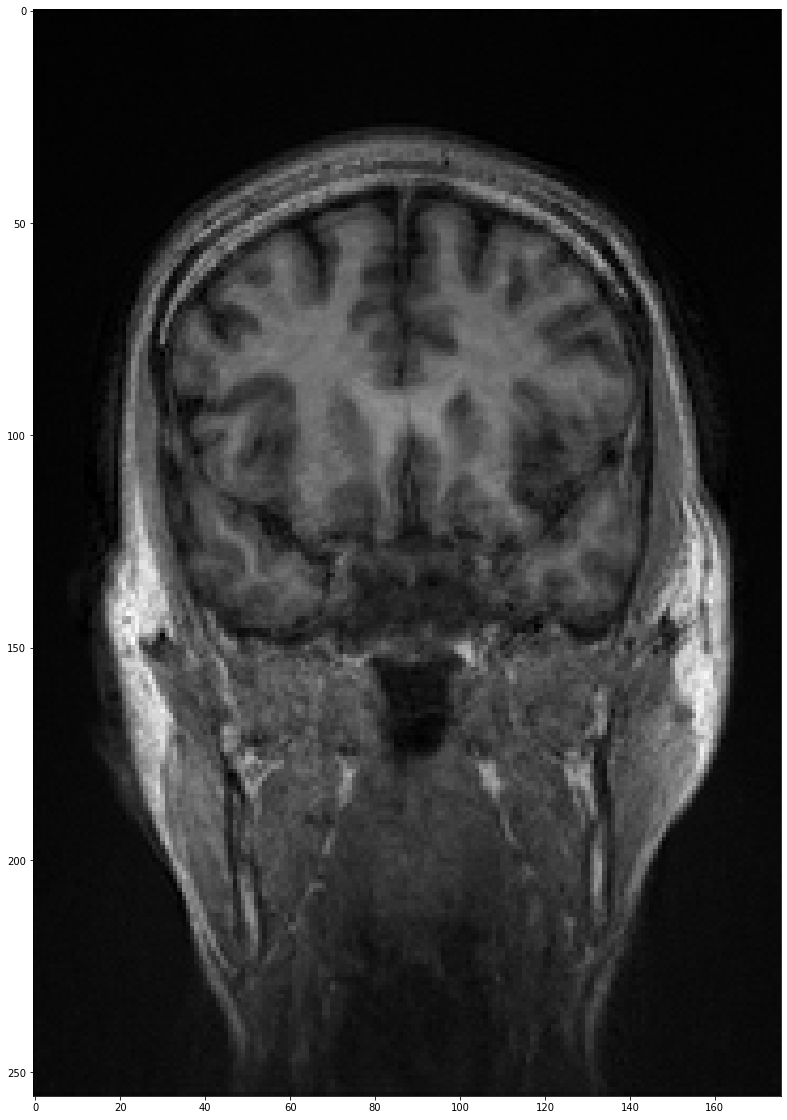

In [0]:
# viewing one of the transformed mris
test_mri = mri('/content/gdrive/My Drive/NU_Rad/transforms2/M12b_orig_trio_motion3.nii')
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(test_mri.original, (2,1,0))[110], cmap='gray')

In [0]:
#testing pickle
mri1 = mri('NU_Radiology/mris/M01.nii')
motion1 = motion('NU_Radiology/motion/motion1.dat')
transf_v, _, mod_log = mri1.create_mod_slices(motion1)

Slice #0 out of 256 completed
Slice #1 out of 256 completed
Slice #2 out of 256 completed
Slice #3 out of 256 completed
Slice #4 out of 256 completed
Slice #5 out of 256 completed
Slice #6 out of 256 completed
Slice #7 out of 256 completed
Slice #8 out of 256 completed
Slice #9 out of 256 completed
Slice #10 out of 256 completed
Slice #11 out of 256 completed
Slice #12 out of 256 completed
Slice #13 out of 256 completed
Slice #14 out of 256 completed
Slice #15 out of 256 completed
Slice #16 out of 256 completed


KeyboardInterrupt: ignored

In [0]:
# Full pipeline

mris_folder = 'gdrive/My Drive/NU_Rad/mris/'
motion_folder = 'gdrive/My Drive/NU_Rad/motion/'
cache_folder = 'gdrive/My Drive/NU_Rad/cache/'
out_folder = 'gdrive/My Drive/NU_Rad/transforms2/'

global start_time
global slice_time

start_time = time.time()
slice_time = time.time()

for item in os.listdir(mris_folder):
    if item.endswith(".nii"):
        mri1 = mri(mris_folder + item)
        for mot_file in os.listdir(motion_folder):
            suffix = '/' + item[:-4] + '_' + mot_file[:-4]
            motion1 = motion(motion_folder + mot_file)
            
            print('Processing mri: {}, motion: {}'.format(item,mot_file))
            transf_v, _, mod_log = mri1.create_mod_slices(motion1)
            
            np.savetxt(out_folder + suffix + '_1mod.txt', mod_log, fmt="%s" ,delimiter=',')
            print('Cache saved for mri: {}, motion: {}'.format(item,mot_file))

            mri1.save_to_file(transf_v, out_folder + suffix + '_trans_1mod.txt.gz')
            print('Modified vis saved for mri: {}, motion: {}'.format(item,mot_file))
            print('Time since start: ' + str(time.time() - start_time)[0:5])
#             os.remove(cache_folder + suffix + '_k' + '_r.txt.gz')
#             print('Cache deleted: ' + cache_folder + suffix + '_k' + '_r.txt.gz')
#             os.remove(cache_folder + suffix + '_k' + '_i.txt.gz')
#             print('Cache deleted: ' + cache_folder + suffix + '_k' + '_i.txt.gz')

print('Total Time: ' + str(time.time() - start_time))

Processing mri: M02.nii, motion: motion5.dat


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 234, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
_pickle.PicklingError: Can't pickle <class '__main__.mri'>: it's not the same object as __main__.mri
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 234, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
_pickle.PicklingError: Can't pickle <class '__main__.mri'>: it's not the same object as __main__.mri


KeyboardInterrupt: ignored

In [0]:
# Full Pipeline multiprocessing

import multiprocessing
import concurrent.futures

mris_folder = 'gdrive/My Drive/NU_Rad/mris/'
motion_folder = 'gdrive/My Drive/NU_Rad/motion/'
cache_folder = 'gdrive/My Drive/NU_Rad/cache/'
out_folder = 'gdrive/My Drive/NU_Rad/transforms2/'

global start_time
start_time = time.time()

def process_files(mot_file, item, mri1):
    suffix = '/' + item[:-4] + '_' + mot_file[:-4]
    motion1 = motion(motion_folder + mot_file)
    
    print('Processing mri: {}, motion: {}'.format(item,mot_file))
    transf_v, _, mod_log = mri1.create_mod_slices(motion1)
    
    np.savetxt(out_folder + suffix + '_1mod.txt', mod_log, fmt="%s" ,delimiter=',')
    print('Cache saved for mri: {}, motion: {}'.format(item,mot_file))

    mri1.save_to_file(transf_v, out_folder + suffix + '_trans_1mod.txt.gz')
    print('Modified vis saved for mri: {}, motion: {}'.format(item,mot_file))
    print('Time since start: ' + str(time.time() - start_time)[0:5])
#             os.remove(cache_folder + suffix + '_k' + '_r.txt.gz')
#             print('Cache deleted: ' + cache_folder + suffix + '_k' + '_r.txt.gz')
#             os.remove(cache_folder + suffix + '_k' + '_i.txt.gz')
#             print('Cache deleted: ' + cache_folder + suffix + '_k' + '_i.txt.gz')

with concurrent.futures.ProcessPoolExecutor() as executor:
    processes = []
    for item in os.listdir(mris_folder):
        if item.endswith(".nii"):
            mri1 = mri(mris_folder + item)
            for mot_file in os.listdir(motion_folder):
                processes.append(executor.submit(process_files, mot_file, item, mri1))

Processing mri: M02.nii, motion: motion5.dat
Processing mri: M02.nii, motion: motion3.dat
Slice #0 out of 256 completed
Slice #0 out of 256 completed
Slice #1 out of 256 completed
Slice #1 out of 256 completed
Slice #2 out of 256 completed
Slice #2 out of 256 completed
Slice #3 out of 256 completed
Slice #3 out of 256 completed
Slice #4 out of 256 completed
Slice #4 out of 256 completed
Slice #5 out of 256 completed
Slice #5 out of 256 completed
Slice #6 out of 256 completed
Slice #6 out of 256 completed
Slice #7 out of 256 completed
Slice #7 out of 256 completed
Slice #8 out of 256 completed
Slice #8 out of 256 completed
Slice #9 out of 256 completed
Slice #9 out of 256 completed
Slice #10 out of 256 completed
Slice #10 out of 256 completed
Slice #11 out of 256 completed
Slice #11 out of 256 completed
Slice #12 out of 256 completed
Slice #12 out of 256 completed
Slice #13 out of 256 completed
Slice #13 out of 256 completed
Slice #14 out of 256 completed
Slice #14 out of 256 completed


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/concurrent/futures/process.py", line 295, in _queue_management_worker
    shutdown_worker()
  File "/usr/lib/python3.6/concurrent/futures/process.py", line 253, in shutdown_worker
    call_queue.put_nowait(None)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 129, in put_nowait
    return self.put(obj, False)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 83, in put
    raise Full
queue.Full



In [0]:
mri1.save_to_file(mod_k, '/content/gdrive/My Drive/mri1_kspace')
mri1.save_to_file(mod_v, '/content/gdrive/My Drive/mri1_vspace')

(Text(0.5, 1.0, 'K-space'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

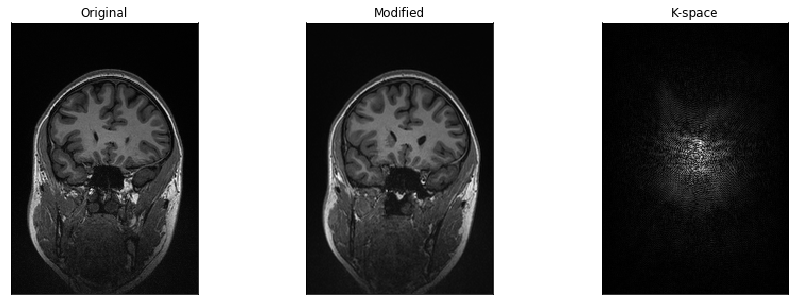

In [0]:
# testing out mod_kspace_slice
rot = [motion1.yaw[0], motion1.pitch[0], motion1.roll[0]]
trans = [motion1.trans_x[0], motion1.trans_y[0], motion1.trans_z[0]]
slice_num = 100
modded_k, modded_v = mri1.mod_kspace_slice(trans,rot,slice_num)
modded_k_vis = np.abs(modded_k)
plt.figure(figsize= (15,5))
plt.subplot(131), plt.imshow(img[slice_num], cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(modded_v, cmap='gray')
plt.title('Modified'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(modded_k_vis, cmap='gray')
plt.title('K-space'), plt.xticks([]), plt.yticks([])

Slice #0 out of 256 completed
Slice #3 out of 256 completed
Slice #6 out of 256 completed
Slice #9 out of 256 completed
Slice #12 out of 256 completed
Slice #15 out of 256 completed
Slice #18 out of 256 completed
Slice #21 out of 256 completed
Slice #24 out of 256 completed
Slice #27 out of 256 completed
Slice #30 out of 256 completed
Slice #33 out of 256 completed
Slice #36 out of 256 completed
Slice #39 out of 256 completed
Slice #42 out of 256 completed
Slice #45 out of 256 completed
Slice #48 out of 256 completed
Slice #51 out of 256 completed
Slice #54 out of 256 completed
Slice #57 out of 256 completed
Slice #60 out of 256 completed
Slice #63 out of 256 completed
Slice #66 out of 256 completed
Slice #69 out of 256 completed
Slice #72 out of 256 completed
Slice #75 out of 256 completed
Slice #78 out of 256 completed
Slice #81 out of 256 completed
Slice #84 out of 256 completed
Slice #87 out of 256 completed
Slice #90 out of 256 completed
Slice #93 out of 256 completed
Slice #96 ou

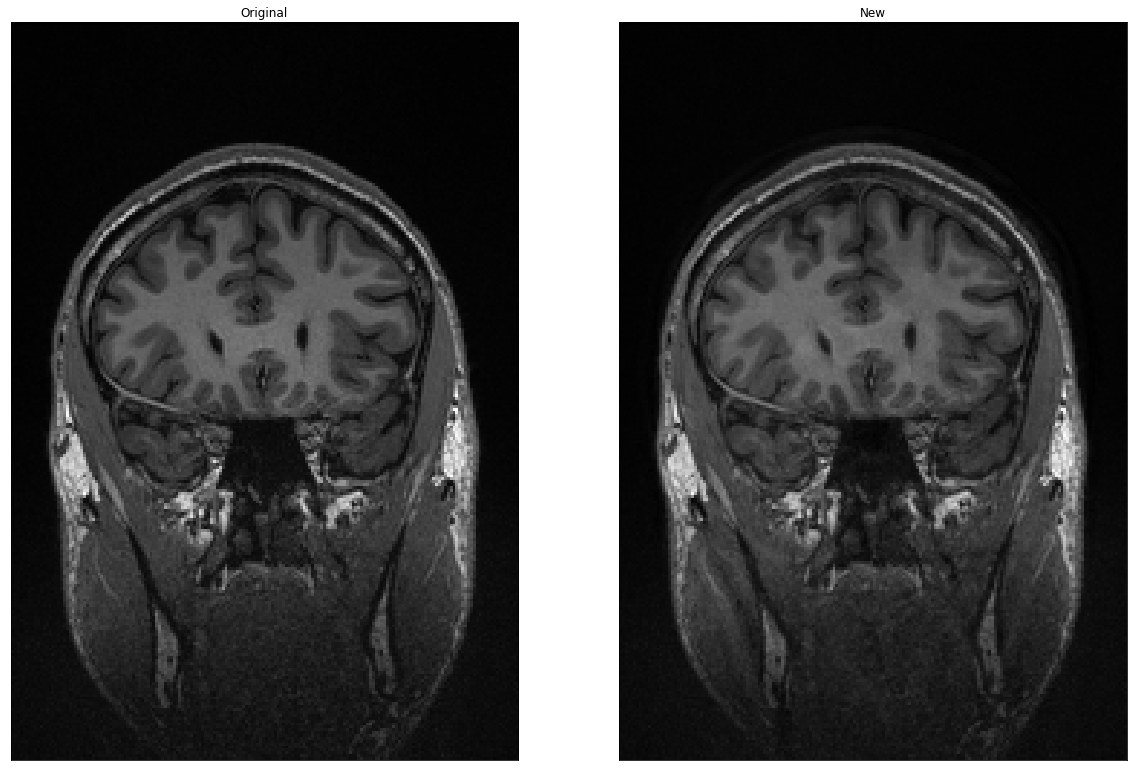

In [0]:
# Testing out pipeline for one file, translation with x1 scale

mri1 = mri('gdrive/My Drive/NU_Rad/mris/M02.nii')
motion1 = motion('gdrive/My Drive/NU_Rad/motion/motion5.dat')
transf_v, mod_v, mod_log = mri1.create_mod_slices(motion1)

mri1.show_slice(transf_v[100], 100, 'v')

In [0]:
# Read in saved kspace file

k_r = np.loadtxt('/content/gdrive/My Drive/mri1_kspace_r.txt.gz', delimiter=",")
k_i = np.loadtxt('/content/gdrive/My Drive/mri1_kspace_i.txt.gz', delimiter=",")
k_r = np.reshape(k_r,image_shape)
k_i = np.reshape(k_i,image_shape)

kspace = k_r + k_i*1j


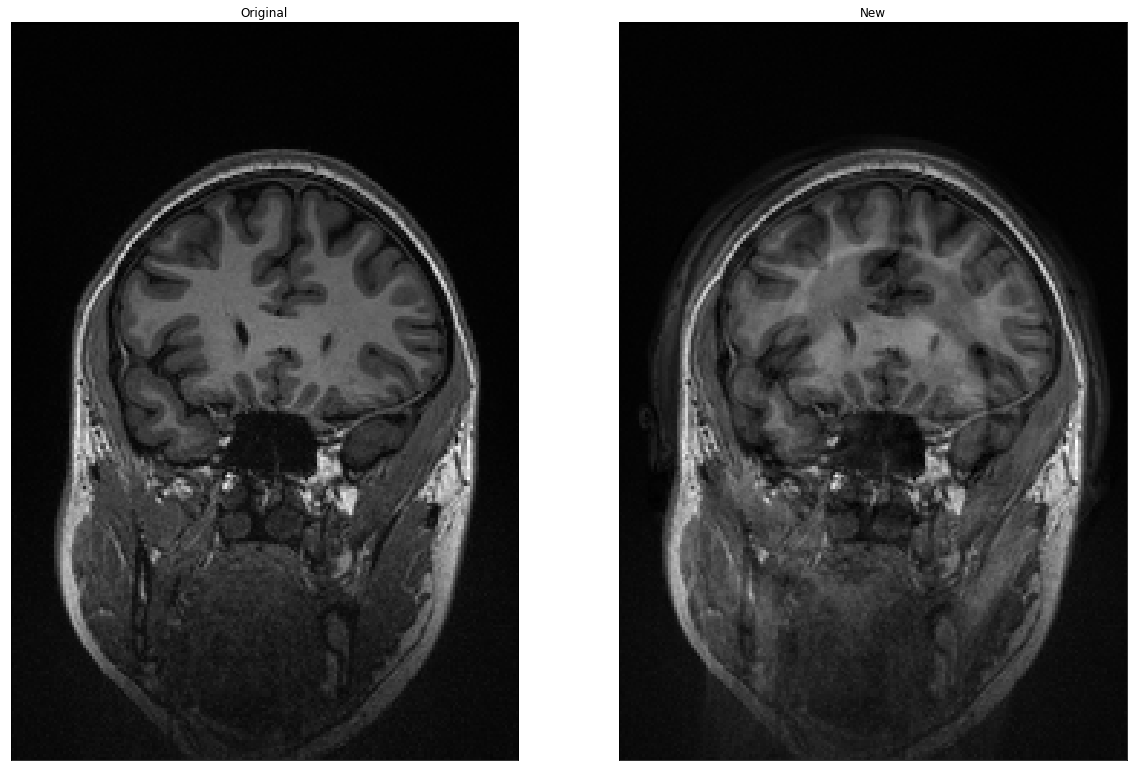

In [0]:
new_vis = mri1.fft_back(kspace)
mri1.save_to_file(new_vis, '/content/gdrive/My Drive/mri1_transf_v')
mri1.show_slice(np.abs(new_vis[100]), 100, 'v')

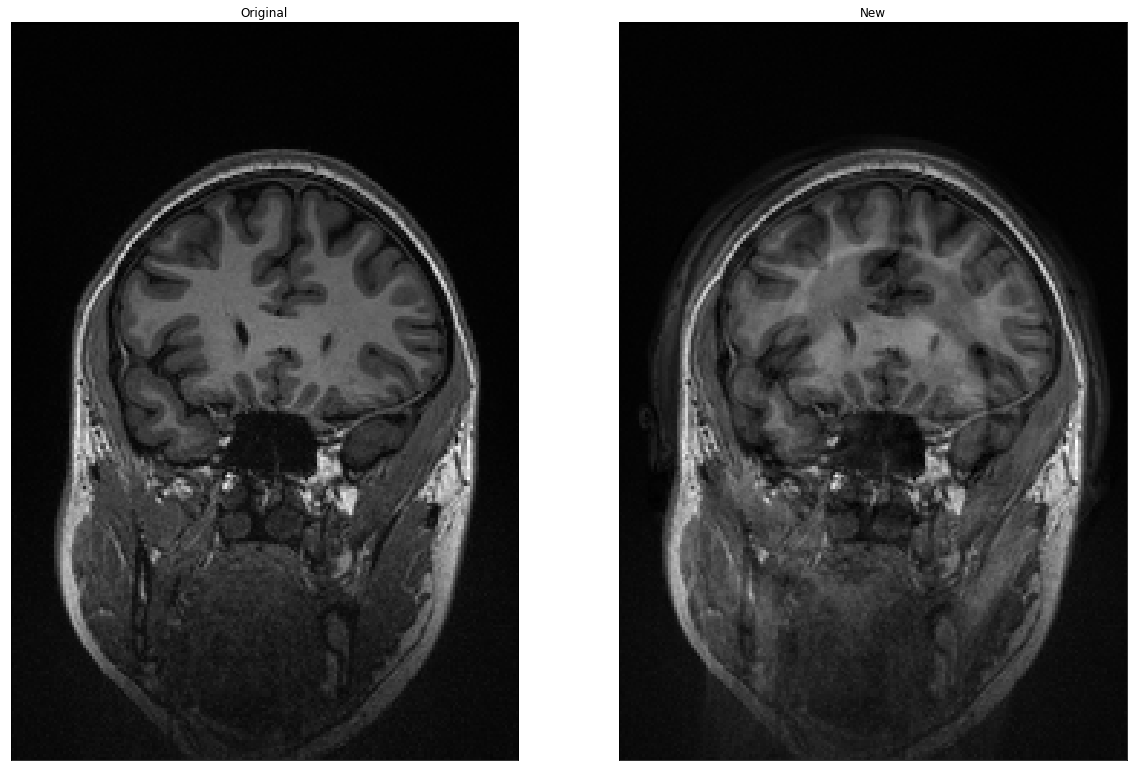

In [0]:
new_vis = mri1.fft_back(kspace)
mri1.save_to_file(new_vis, '/content/gdrive/My Drive/mri1_transf_v')
mri1.show_slice(np.abs(new_vis[100]), 100, 'v')


In [0]:
mod_r = np.loadtxt('/content/gdrive/My Drive/mri1_transf_v_r.txt.gz', delimiter=",")
mod_i = np.loadtxt('/content/gdrive/My Drive/mri1_transf_v_i.txt.gz', delimiter=",")
mod_r = np.reshape(mod_r,image_shape)
mod_i = np.reshape(mod_i,image_shape)
mod_full = np.abs(mod_r + mod_i*1j)

rot_r = np.loadtxt('/content/gdrive/My Drive/mri1_vspace_r.txt.gz', delimiter=",")
rot_i = np.loadtxt('/content/gdrive/My Drive/mri1_vspace_i.txt.gz', delimiter=",")
rot_r = np.reshape(rot_r,image_shape)
rot_i = np.reshape(rot_i,image_shape)
rot_full = np.abs(rot_r + rot_i*1j)

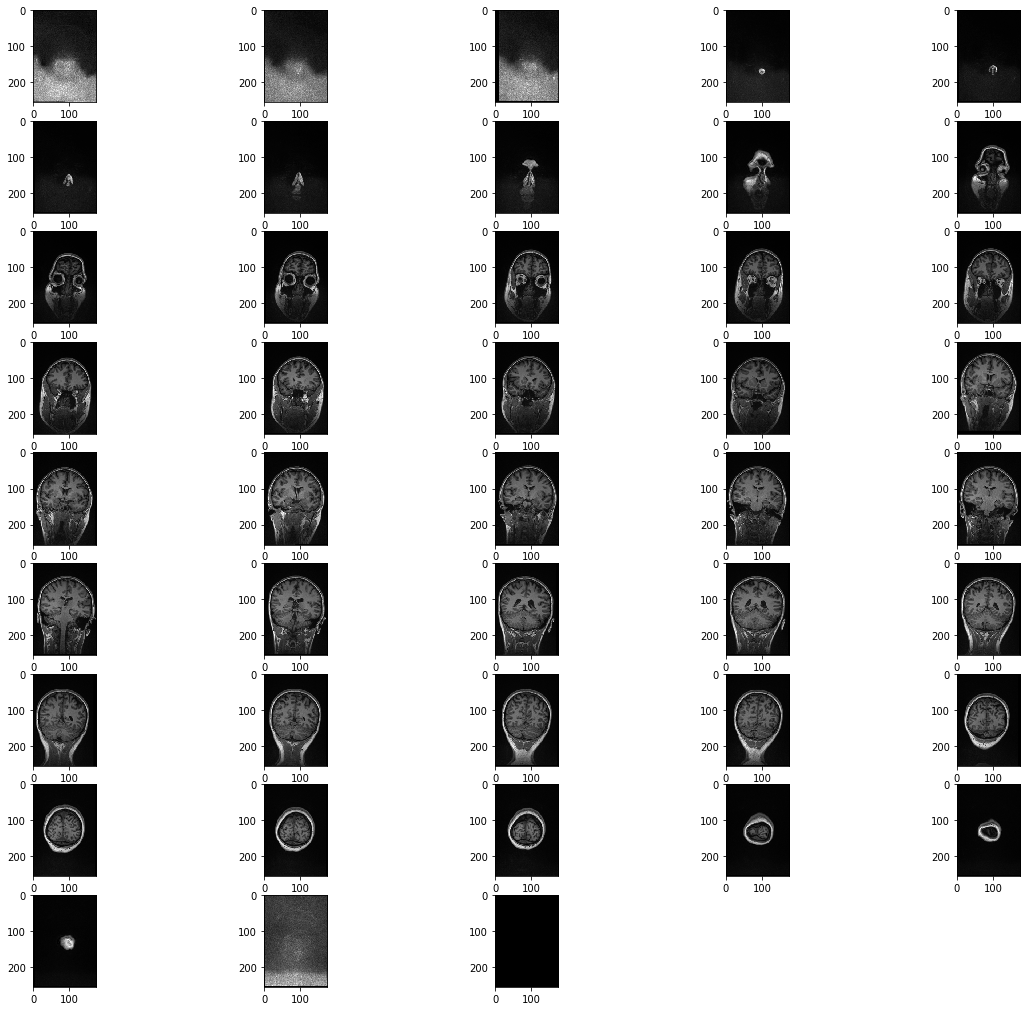

In [0]:
rot_full = np.abs(rot_r + rot_i*1j)
mri1.show_rotations(rot_full)

In [0]:
mri1 = mri('gdrive/My Drive/NU_Rad/mris/M01.nii')
motion1 = motion('gdrive/My Drive/NU_Rad/motion/motion1.dat')


In [0]:
transf_v, modded_v, trans_log = mri1.create_mod_slices(motion1)
modded_v = np.transpose(modded_v,(2,1,0))
transf_v = np.transpose(transf_v,(2,1,0))
mri1.save_to_file(transf_v, 'gdrive/My Drive/NU_Rad/cache/M01_motion1_transf.txt.gz')
mri1.show_rotations(transf_v)

Slice #0 out of 256 completed
Slice #1 out of 256 completed
Slice #2 out of 256 completed
Slice #3 out of 256 completed
Slice #4 out of 256 completed
Slice #5 out of 256 completed
Slice #6 out of 256 completed
Slice #7 out of 256 completed
Slice #8 out of 256 completed
Slice #9 out of 256 completed
Slice #10 out of 256 completed
Slice #11 out of 256 completed
Slice #12 out of 256 completed
Slice #13 out of 256 completed
Slice #14 out of 256 completed
Slice #15 out of 256 completed
Slice #16 out of 256 completed
Slice #17 out of 256 completed
Slice #18 out of 256 completed
Slice #19 out of 256 completed
Slice #20 out of 256 completed
Slice #21 out of 256 completed
Slice #22 out of 256 completed
Slice #23 out of 256 completed
Slice #24 out of 256 completed
Slice #25 out of 256 completed
Slice #26 out of 256 completed
Slice #27 out of 256 completed
Slice #28 out of 256 completed
Slice #29 out of 256 completed
Slice #30 out of 256 completed
Slice #31 out of 256 completed
Slice #32 out of 2

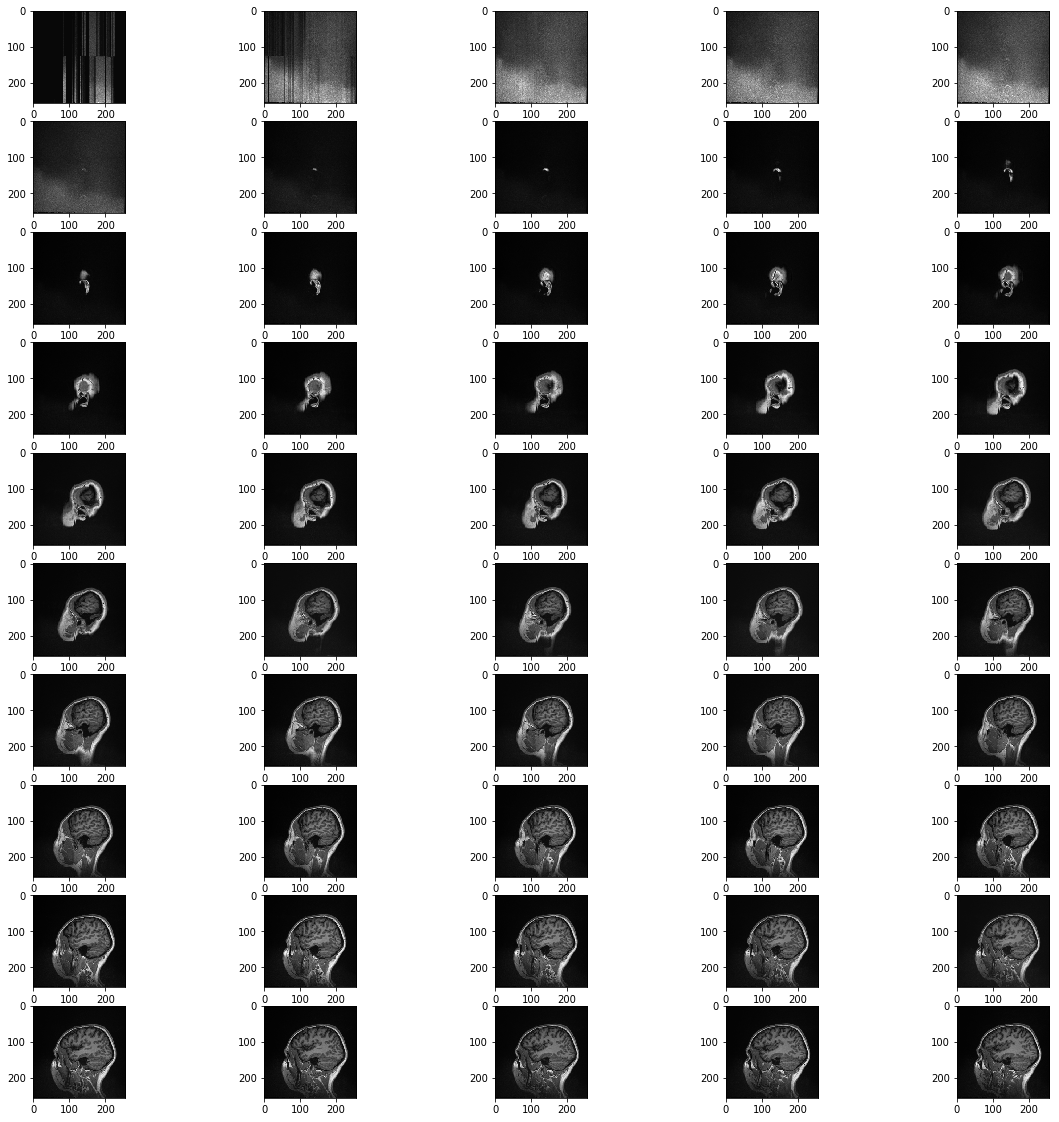

In [0]:
mri1.show_rotations(modded_v)

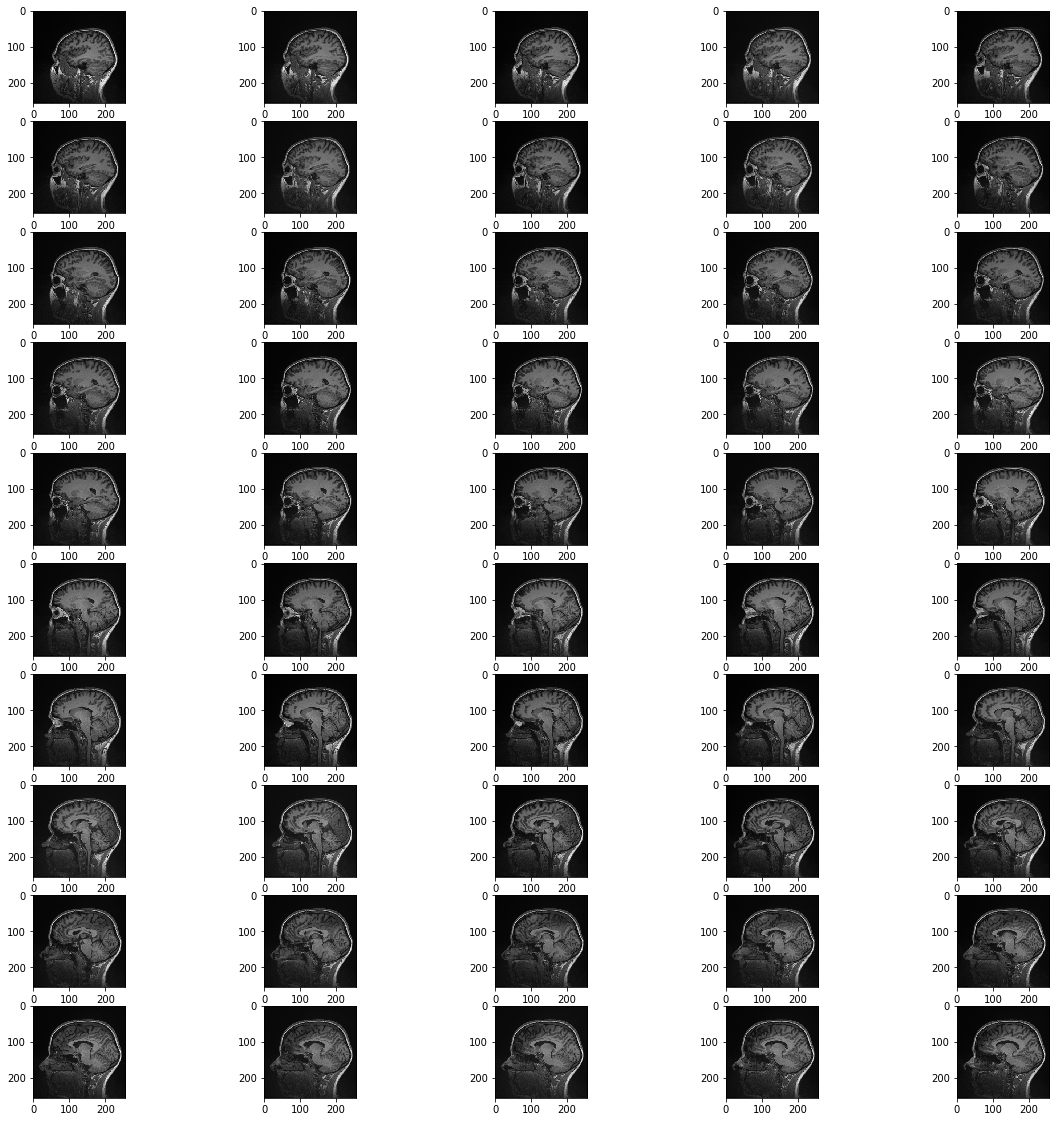

In [0]:
mri1.show_rotations(modded_v[50:])

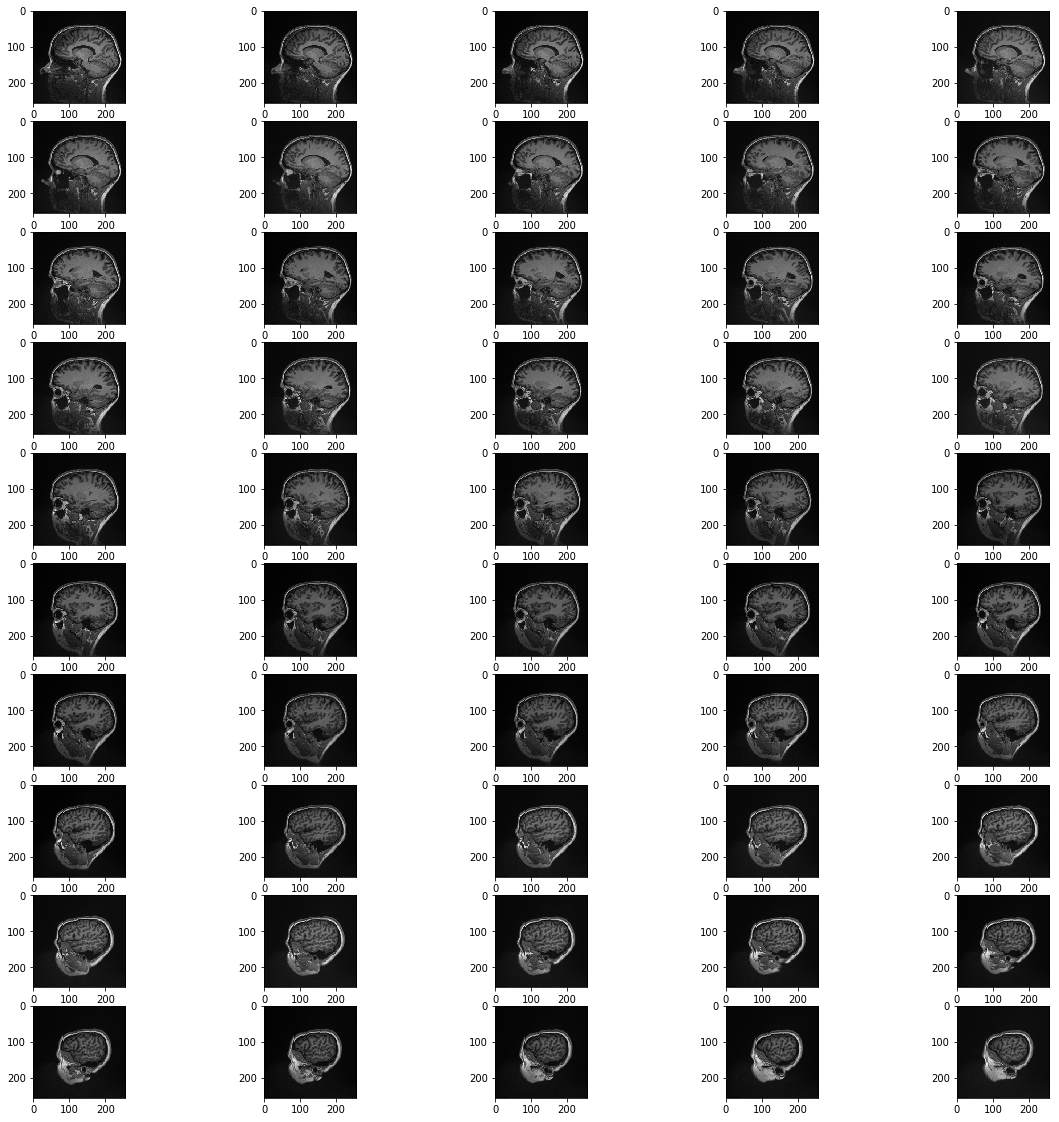

In [0]:
mri1.show_rotations(modded_v[100:])

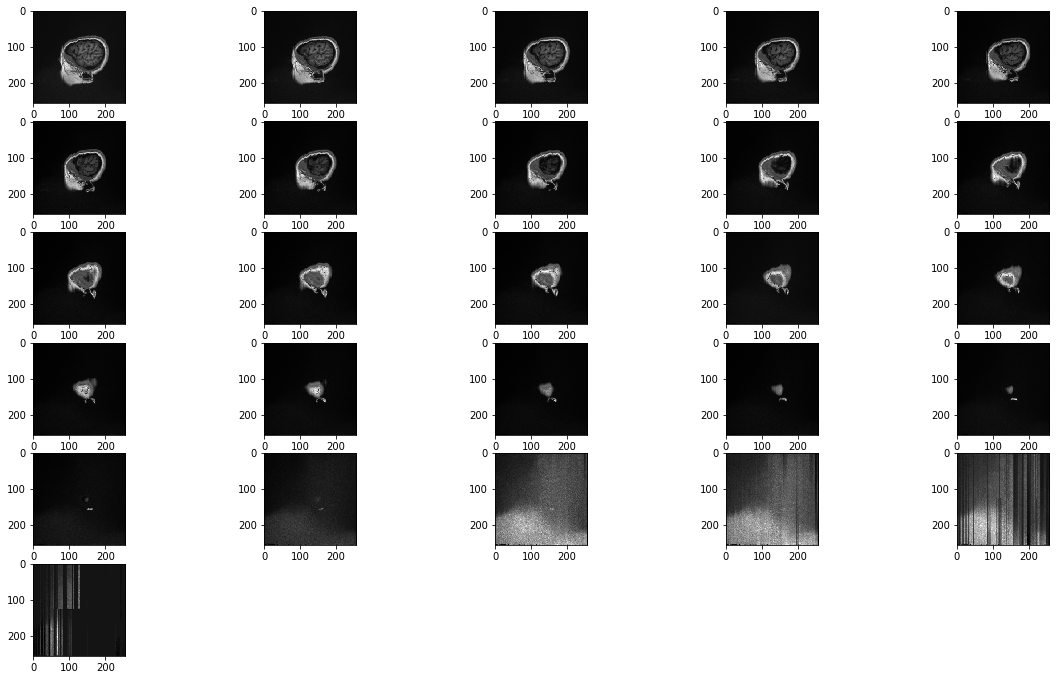

In [0]:
mri1.show_rotations(modded_v[150:])

In [0]:
transf_v.shape()

NameError: ignored

In [0]:
# To Do
# Processing images
#     Make it so it caches the 3d image as it goes, and then outputs a 3d visual
#     Naming scheme- mri#_v, mri#_rot (text file of which slice, and transformations)
# Model
#     Take in image of this size